### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.analyses import detect_pbe_epochs
import pandas as pd
from scipy import stats
import seaborn as sns
from neuropy.plotting import Fig

import subjects

### Single session

In [ ]:
sess = subjects.sd.ratUday1[0]
post = sess.paradigm["post"].flatten()
epochs = sess.get_zt_epochs(include_maze=False)

pbes = sess.replay_pbe.starts
hist_pbe = np.histogram(pbes, bins=epochs.flatten())[0][::2]
rate = hist_pbe / epochs.durations

_, ax = plt.subplots()

ax.plot(epochs.labels, rate)

### Pbe rate change across sleep deprivation

In [ ]:
sessions = subjects.mua_sess()
# sessions = subjects.sd.ratUday1
# sessions = subjects.nsd.ratRday1 + subjects.sd.ratUday1
# sessions = subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2
print(f"#Sessions:{len(sessions)}")
pbe_rate_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    epochs = sess.get_zt_epochs(include_maze=False)

    pbes = sess.pbe.starts
    hist_pbe = np.histogram(pbes, bins=epochs.flatten())[0][::2]

    pbe_rate_df.append(
        pd.DataFrame(
            {
                "rate": hist_pbe / epochs.durations,
                "zt": epochs.labels,
                "session": sub,
                "grp": sess.tag,
            }
        ),
    )

pbe_rate_df = pd.concat(pbe_rate_df, ignore_index=True)
subjects.GroupData().save(pbe_rate_df, "pbe_rate")

In [ ]:
from statannotations.Annotator import Annotator

fig = Fig(grid=(5, 4))

for i, grp in enumerate(["NSD", "SD"]):
    df = pbe_rate_df[pbe_rate_df["grp"] == grp]
    ax = plt.subplot(fig.gs[i])
    sns.lineplot(
        data=df,
        x="zt",
        y="rate",
        ax=ax,
        hue="session",
        legend=False,
        # palette="#BDBDBD",
        # ls="--",
    )
    sns.lineplot(
        data=df,
        x="zt",
        y="rate",
        estimator=np.median,
        ax=ax,
        legend=False,
        color="k",
        ls="--",
        ci=None,
        lw=2,
    )
    orders = df.zt.unique()
    pairs = [(orders[t1], orders[t2]) for t1, t2 in zip([0, 1, 2], [1, 2, 0])]

    annotator = Annotator(
        ax,
        pairs,
        data=df,
        x="zt",
        y="rate",
        order=orders,
        # hue="grp",
        # hue_order=group,
    )
    annotator.configure(
        test="Wilcoxon", text_format="star", loc="outside", verbose=False
    )

    annotator.apply_and_annotate()

    # ax.set_yscale('log')
    # ax.set_ylim([0.08, 0.65])
    # ax.set_xticks(np.arange(1, 10, 2))

# figure.savefig(subjects.figpath_sd/'ripple_rate')

### Total/mean pbe duration from first hour to last hour SD

In [ ]:
sessions = subjects.nsd.mua_sess + subjects.sd.mua_sess

In [ ]:
pbe_duration = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zts = np.array([0, 2.5, 5])
    starts = zts * 3600 + post[0]
    stops = starts + 2.5 * 3600

    # POST is not necessarily 9 hours long
    # stops[-1] = np.min([post[1],stops[-1]])

    for i, (t1, t2) in enumerate(zip(starts, stops)):
        pbe_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"{zts[i]}-{zts[i]+2.5}",
                    "pbe_duration": [sess.pbe.time_slice(t1, t2).durations.sum()],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
        )

pbe_duration = pd.concat(pbe_duration, ignore_index=True)
subjects.GroupData().save(pbe_duration, "pbe_total_duration")

In [ ]:
import seaborn as sns
from neuropy import plotting

fig = plotting.Fig(grid=(4, 3))
n_subs = [7, 6]
for i, grp in enumerate(["SD", "NSD"]):
    data = pbe_duration[pbe_duration["grp"] == grp]
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="pbe_duration",
        # hue="sub",
        marker="o",
        palette=["gray"] * n_subs[i],
        ax=ax,
        legend=None,
    )
    # ax.set_xlim([-1,6])
    # ax.set_ylim([30,450])


# g=sns.relplot(
#     data=rpl_duration,
#     x="epoch",
#     y="rpl_duration",
#     hue="sub",
#     col="grp",
#     # row='rpl_duration',
#     kind="line",
#     marker="o",
#     palette=['gray']*len(sessions),
# )

# [ax.set_xlim([-1,2]) for ax in g.axes.reshape(-1)]
# figure.savefig(subjects.figpath_sd/'ripple_total_duration_zt1_vs_zt5')

### PBE vs Ripples
- Does each pbe event comprises of only one ripple or more. How that varies across time during SD vs NSD.
- Plot similar to fig5A of Davidson et al. 2009, but using PBE duration in the x-axis instead of replay event duration.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

In [ ]:
rpl_vs_pbe_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    epoch = [post[0] + 0 * 3600, post[0] + 1 * 3600]
    pbe = sess.pbe.time_slice(*epoch)
    pbe_duration = pbe.durations
    pbe_bins = pbe.flatten()
    rpl_peaktime = sess.ripple.time_slice(*epoch).to_dataframe().start.values

    rpl_per_pbe = np.histogram(rpl_peaktime, bins=pbe_bins)[0][::2]

    df = pd.DataFrame(dict(n_rpls=rpl_per_pbe, pbe_duration=pbe_duration, grp=sess.tag))
    rpl_vs_pbe_df.append(df)

rpl_vs_pbe_df = pd.concat(rpl_vs_pbe_df, ignore_index=True)
rpl_vs_pbe_df["n_rpls"] = (
    rpl_vs_pbe_df["n_rpls"] + np.random.random(len(rpl_vs_pbe_df)) * 0.1
)

In [ ]:
%matplotlib widget
import seaborn as sns

sns.scatterplot(
    data=rpl_vs_pbe_df,
    x="pbe_duration",
    y="n_rpls",
    hue="grp",
    hue_order=['NSD','SD'],
    palette=subjects.colors_sd(1.2),
    # split=True,
    # showfliers=False,
)


### Ripple band and number of peaks during PBEs
- Question: Am I over-merging during sleep deprivation compared to regular sleep.
- Here I am comparing the number of hilbert peaks (proxy for ripples) within each PBE. 
- Results: Not seeing anything interesting

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

rpl_channels = [39, 63, 111, 95, 49, 100, 85, 63, 63, 36, 188, 99, 86]

In [ ]:
from neuropy.utils.signal_process import filter_sig, hilbertfast
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

peak_rate = []
rpl_vs_pbe_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zt = np.array([0, 4])
    starts = zt * 3600 + post[0]

    srate = sess.eegfile.sampling_rate
    dt = 1 / srate
    smooth_window = 0.01  # 20 ms
    sigma = smooth_window / dt

    peak_rate_sub = []
    for i, s in enumerate(starts):
        pbe = sess.pbe.time_slice(s, s + 3600)

        rpl_lfp, time = sess.eegfile.get_frames_within_epochs(
            pbe, rpl_channels[sub], ret_time=True
        )
        rpl_bp = filter_sig.bandpass(rpl_lfp, fs=1250, lf=125, hf=250)
        hilbert_amp = np.abs(hilbertfast(rpl_bp))

        hilbert_smth = gaussian_filter1d(hilbert_amp, sigma=sigma)
        hilbert_smth_zsc = stats.zscore(hilbert_smth)

        peaks = find_peaks(hilbert_smth_zsc, height=1)[0]
        peak_rate_sub.append(len(peaks) / len(pbe))

        peaks_time = time[peaks]
        pbe_bins = pbe.flatten()
        rpl_per_pbe = np.histogram(peaks_time, bins=pbe_bins)[0][::2]
        df = pd.DataFrame(
            dict(n_rpls=rpl_per_pbe, pbe_duration=pbe.durations, zt=zt[i], grp=sess.tag)
        )
        rpl_vs_pbe_df.append(df)

    df = pd.DataFrame(dict(zt=zt, peak_rate=peak_rate_sub, grp=sess.tag))
    peak_rate.append(df)

peak_rate = pd.concat(peak_rate, ignore_index=True)
rpl_vs_pbe_df = pd.concat(rpl_vs_pbe_df, ignore_index=True)

In [ ]:
import seaborn as sns
from neuropy.plotting import Fig

fig = Fig(grid=(4, 3), fontsize=12, wspace=0.4, hspace=0.5)
ax = fig.subplot(fig.gs[0])
sns.boxplot(
    data=peak_rate,
    x="zt",
    y="peak_rate",
    hue="grp",
    hue_order=["NSD", "SD"],
    palette=subjects.colors_sd(1.6),
)
sns.swarmplot(
    data=peak_rate,
    x="zt",
    y="peak_rate",
    hue="grp",
    hue_order=["NSD", "SD"],
    palette=subjects.colors_sd(1),
    dodge=True,
    size=8,
    # edgecolors='w',
)
ax.set_xticks([0, 1], ["0-1", "4-5"])
ax.set_xlabel("Zt time (h)")
ax.set_ylabel("# hilbert peaks every PBE")
ax.set_title("Number of ripples\nin PBE")
ax.legend([], frameon=False)
fig.legend(ax, ["NSD", "SD"], subjects.colors_sd(1.4), x=0.8, dy=0.1, fontsize=10)


for i, grp in enumerate(["NSD", "SD"]):
    for i1, t in enumerate([0, 4]):
        ax = fig.subplot(fig.gs[i, i1 + 1])
        df = rpl_vs_pbe_df[(rpl_vs_pbe_df["grp"] == grp) & (rpl_vs_pbe_df["zt"] == t)]
        df = df[df["n_rpls"] > 0]
        x = df.pbe_duration.values
        y = df.n_rpls.values + np.random.random(len(df)) * 0.3
        linfit = stats.linregress(x, y)

        ax.scatter(
            x,
            y,
            edgecolors=subjects.colors_sd(1.2)[i],
            s=10,
            marker="o",
            facecolors="w",
        )
        ax.plot(x, linfit.slope * x + linfit.intercept, color="k", linewidth=2)
        if t == 0:
            ax.set_ylabel("#hilbert peaks (>1 s.d.)")
        if i == 1:
            ax.set_xlabel("PBE duration (s)")
        ax.set_title(f"Zt{t}-{t+1}, r={linfit.rvalue.round(2)}")
        ax.set_ylim([0, 8])

### PBE duration scatter plot/ linear regression

In [ ]:
sessions = subjects.nsd.mua_sess + subjects.sd.mua_sess

In [ ]:
pbe_duration = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zts = np.arange(0, 5, 5 / 60)  # 5 minute bins
    starts = zts * 3600 + post[0]
    stops = starts + 300

    # POST is not necessarily 9 hours long
    # stops[-1] = np.min([post[1],stops[-1]])

    for i, (t1, t2) in enumerate(zip(starts, stops)):
        pbe_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"{zts[i].round(2)}",
                    "pbe_duration": [sess.pbe.time_slice(t1, t2).durations.size],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
        )

pbe_duration = pd.concat(pbe_duration, ignore_index=True)
# subjects.GroupData().save(pbe_duration, "pbe_total_duration")

In [ ]:
import seaborn as sns
from neuropy import plotting

fig = plotting.Fig(grid=(4, 3))
n_subs = [7, 6]
for i, grp in enumerate(["SD", "NSD"]):
    data = pbe_duration[pbe_duration["grp"] == grp]
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="pbe_duration",
        hue="sub",
        marker="o",
        palette=["gray"] * n_subs[i],
        ax=ax,
        legend=None,
    )
    # ax.set_xlim([-1,6])
    # ax.set_ylim([30,450])
    ax.set_xticks([0, 2, 5, 7])
    # ax.set_yscale('log')

# g=sns.relplot(
#     data=rpl_duration,
#     x="epoch",
#     y="rpl_duration",
#     hue="sub",
#     col="grp",
#     # row='rpl_duration',
#     kind="line",
#     marker="o",
#     palette=['gray']*len(sessions),
# )

# [ax.set_xlim([-1,2]) for ax in g.axes.reshape(-1)]
# figure.savefig(subjects.figpath_sd/'ripple_total_duration_zt1_vs_zt5')

### PBE durations distribution that satisfy criteria for replay
- SD paper FigS1C

In [2]:
sessions = subjects.pf_sess()

replay_pbe = []
for s, sess in enumerate(sessions):
    all_pbe_df = sess.pbe_filters.to_dataframe()
    good_pbe = (all_pbe_df.is_rpl & all_pbe_df.is_5units & all_pbe_df.is_rest).values
    # good_pbe = (all_pbe_df.is_rpl & all_pbe_df.is_rest).values
    all_pbe_df = all_pbe_df[good_pbe]
    rpl_starts = all_pbe_df.start.values
    rpl_durations = all_pbe_df.duration.values
    epochs = sess.get_zt_epochs()

    for e in epochs.itertuples():
        indx = (rpl_starts >= e.start) & (rpl_starts <= e.stop)
        e_dur = rpl_durations[indx]

        replay_pbe.append(
            pd.DataFrame(
                dict(
                    pbe_duration=e_dur,
                    zt=e.label,
                    session=s,
                    grp=sess.tag,
                )
            )
        )


replay_pbe = pd.concat(replay_pbe, ignore_index=True)

subjects.GroupData().save(replay_pbe, "candidate_PBE_duration")

#Sessions = 13
candidate_PBE_duration saved


In [ ]:
fig = plotting.Fig(grid=(7, 5))

ax = fig.subplot(fig.gs[2, 2])
violinplot(
    replay_pbe, x="zt", y="duration", ax=ax, stat_anot=True, stat_test="t-test_welch"
)
ax.set_ylabel("Ripple duration")
ax.set_ylim(top=0.3)

fig.savefig(subjects.figpath_sd / "replay_pbe_durations")

### PBE durations mean of sessions with mean across all session barplot
- Satisfying replay category
- An alternative to SD paper FigS1C, something like sdfig1E

#Sessions = 13
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MAZE_NSD vs. MAZE_SD: Welch's t-test independent samples, P_val:2.567e-01 t=-1.201e+00
PRE_NSD vs. PRE_SD: Welch's t-test independent samples, P_val:7.778e-01 t=-2.905e-01
0-2.5_NSD vs. 0-2.5_SD: Welch's t-test independent samples, P_val:8.815e-01 t=-1.531e-01
2.5-5_NSD vs. 2.5-5_SD: Welch's t-test independent samples, P_val:2.411e-01 t=1.264e+00
5-7.5_NSD vs. 5-7.5_SD: Welch's t-test independent samples, P_val:1.012e-01 t=1.845e+00
0-2.5_NSD vs. 5-7.5_SD: Welch's t-test independent samples, P_val:5.728e-02 t=2.141e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0-2.5_NSD vs. 2.5-5_NSD: t-test paired samples, P_val:4.530e-01 t=-8.133e-01
PRE_NSD vs. MAZE_NSD:

Text(0, 0.5, 'PBE duration (s)')

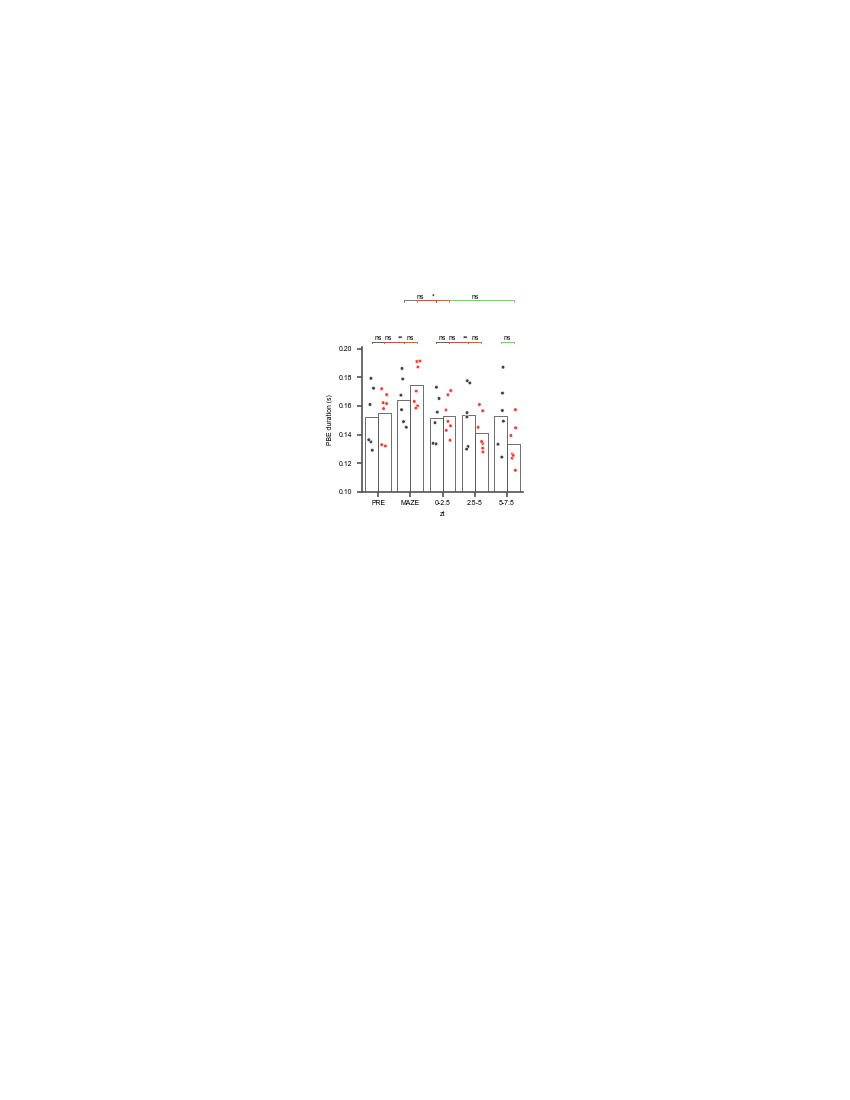

In [2]:
from plotters import violinplot
from statannotations.Annotator import Annotator

sessions = subjects.pf_sess()

replay_pbe = []
for s, sess in enumerate(sessions):
    all_pbe_df = sess.pbe_filters.to_dataframe()
    good_pbe = (all_pbe_df.is_rpl & all_pbe_df.is_5units & all_pbe_df.is_rest).values
    # good_pbe = (all_pbe_df.is_rpl & all_pbe_df.is_rest).values
    all_pbe_df = all_pbe_df[good_pbe]
    rpl_starts = all_pbe_df.start.values
    rpl_durations = all_pbe_df.duration.values
    epochs = sess.get_zt_epochs()

    for e in epochs.itertuples():
        indx = (rpl_starts >= e.start) & (rpl_starts <= e.stop)
        e_dur = rpl_durations[indx]

        replay_pbe.append(
            pd.DataFrame(
                dict(
                    duration=e_dur,
                    zt=e.label,
                    session=s,
                    grp=sess.tag,
                )
            )
        )


replay_pbe = pd.concat(replay_pbe, ignore_index=True)

mean_dur = replay_pbe.groupby(["grp", "session", "zt"], sort=False).mean().reset_index()
mean_sess = mean_dur.groupby(["grp", "zt"], sort=False).mean().reset_index()

fig = plotting.Fig(grid=(7, 5))

ax = fig.subplot(fig.gs[2, 2])
plot_kw = dict(
    data=mean_dur, x="zt", y="duration", hue="grp", hue_order=["NSD", "SD"], ax=ax
)

sns.stripplot(
    **plot_kw,
    palette=subjects.colors_sd(),
    dodge=True,
    edgecolor="w",
    linewidth=0.4,
    size=2.6,
    jitter=0.2
)

sns.barplot(
    data=mean_sess,
    x="zt",
    y="duration",
    hue="grp",
    palette=subjects.colors_sd(1),
    ax=ax,
    facecolor="w",
    linewidth=0.5,
    edgecolor="0.2",
    ci=None,
)
ax.set_ylim(bottom=0.1)
ax.legend("", frameon=False)
# violinplot(
#     replay_pbe, x="zt", y="duration", ax=ax, stat_anot=True, stat_test="t-test_welch"
# )
orders = mean_dur.zt.unique()
pairs = [((_, "NSD"), (_, "SD")) for _ in orders] + [
    (("0-2.5", "NSD"), ("5-7.5", "SD"))
]
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="t-test_welch", **subjects.stat_kw, color="#4AB33E")
annotator.apply_and_annotate()
annotator.reset_configuration()

for i, g in enumerate(["NSD", "SD"]):
    pairs2 = [((orders[_], g), (orders[_ + 1], g)) for _ in range(3)]
    annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
    annotator.configure(
        test="t-test_paired", **subjects.stat_kw, color=subjects.colors_sd(1)[i]
    )
    annotator.apply_and_annotate()
    annotator.reset_configuration()


ax.set_ylabel("PBE duration (s)")
# ax.set_ylim(top=0.3)

# fig.savefig(subjects.figpath_sd / "replay_pbe_durations_mean_session")

#### ANOVA

In [6]:
mean_dur[(mean_dur.zt != "PRE") & (mean_dur.zt != "MAZE")]

,grp,session,zt,duration
2,NSD,0,0-2.5,0.165198
3,NSD,0,2.5-5,0.177534
4,NSD,0,5-7.5,0.186996
7,NSD,1,0-2.5,0.173048
8,NSD,1,2.5-5,0.176040
9,NSD,1,5-7.5,0.168960
12,NSD,2,0-2.5,0.148310
13,NSD,2,2.5-5,0.155300
14,NSD,2,5-7.5,0.149381
17,NSD,3,0-2.5,0.155679


In [5]:
import pingouin as pg

kw = dict(
    data=mean_dur[(mean_dur.zt != "PRE") & (mean_dur.zt != "MAZE")],
    dv="duration",
    within="zt",
    between="grp",
    subject="session",
)
anv = pg.mixed_anova(**kw)
pg.print_table(anv)
posthocs = pg.pairwise_tests(**kw)
pg.print_table(posthocs)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
grp          0.001      1     11  0.001  1.414    0.259  0.114  nan
zt           0.001      2     22  0.000  5.583    0.011  0.337    0.675
Interaction  0.001      2     22  0.000  6.708    0.005  0.379  nan


POST HOC TESTS

Contrast    zt     A      B      Paired    Parametric         T     dof  alternative      p-unc    BF10    hedges
----------  -----  -----  -----  --------  ------------  ------  ------  -------------  -------  ------  --------
zt          -      0-2.5  2.5-5  True      True           2.008  12.000  two-sided        0.068   1.282     0.317
zt          -      0-2.5  5-7.5  True      True           2.127  12.000  two-sided        0.055   1.504     0.537
zt          -      2.5-5  5-7.5  True      True           1.451  12.000  two-sided        0.172   0.653     0.236
grp         -      NSD    SD     False     T

/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
